In [1]:
%load_ext autoreload
%autoreload 2

In [2]:

import os
import json
import pathlib
import pandas as pd
import sys
import shutil


In [3]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import font_manager
%matplotlib inline

In [4]:
# resource configuration
rcParams['figure.dpi'] = 200

# fount information
rcParams['font.family'] = 'Equinor'
rcParams['font.size'] = 9

# fornt location
font_path = r'Equinor_regular'
font_files = font_manager.findSystemFonts(fontpaths=font_path)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

In [5]:
# where python source code located
import sys
code_path = os.path.abspath("../")

sys.path.append(code_path)

In [6]:
# utility modules or functions

from src.WellClass.libs.utils import (
    csv_parser,
    yaml_parser,
)

# WellClass
from src.WellClass.libs.well_class import Well

from src.WellClass.libs.well_pressure import Pressure


from src.WellClass.libs.grid_utils import (
    WellDataFrame,
    GridLGR,
    LGRBuilder,
)

# plots
from src.WellClass.libs.plotting import (
    plot_pressure,
    plot_pt,
    plot_sketch,
)


In [7]:
!pwd


/scratch/SCS/gpb/SCREEN/junk/SCREEN/notebooks


In [8]:
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

# Set up case scenario

In [9]:
# # Examples
cosmo = {
        'well_input': r'cosmo.yaml', 
        # 'well_input': r'cosmo.csv',
        'simcase1': r'PFT_SCREEN_NOSIM',    # for dry run, defined in 'model' folder
        'simcase2': r'PFT_SCREEN',          # for lgr run, defined in 'model' folder
        }

In [10]:
# Set personal location of folder where all files will bve copied and simulation path set up

source_path = r'../test_data/examples/cosmo/'

source_path = pathlib.Path(source_path)


# the user choice of root path for simulation

sim_path = r'/scratch/SCS/gpb/SCREEN/cases/cosmo'

sim_path = pathlib.Path(sim_path)


#Create case folder
#TO DO: To evaluate if it is needed to keep old versions of case folder
if sim_path.exists():
        shutil.rmtree(sim_path.as_posix())

sim_path.mkdir()

#Create simulation folders for input deck and include files
pathlib.Path.mkdir(sim_path / 'model')
pathlib.Path.mkdir(sim_path / 'include')

#Paths for simulation case with and without LGR
simcase1_path = (sim_path / 'model' / cosmo['simcase1']) #No simulation
simcase2_path = (sim_path / 'model' / cosmo['simcase2']) #Full simulation

sim_grid1_path = (sim_path / 'include' / 'BASE_GRD.grdecl')
sim_grid2_path = (sim_path / 'include' / 'BASE_GRD_NOSIM.grdecl')

#Copy standard input deck and dome shaped GRDECL
shutil.copy('../src/setup_grid/PFT_DECK.in',  simcase2_path.with_suffix('.in'))
shutil.copy('../src/setup_grid/BASE_GRD.grdecl', sim_grid1_path )
shutil.copy('../src/setup_grid/BASE_GRD.grdecl', sim_grid1_path )
shutil.copy('../src/setup_grid/temperature_gradient.inc', sim_path / 'include' )
shutil.copy('../src/setup_grid/co2_db_new.dat', sim_path / 'include' )


# Change final date to be the same sa start date to set a NOSIM case 
with open(simcase2_path.with_suffix('.in'), 'r') as file:
        data = file.readlines()
        for idx,  line in enumerate(data):
                if sim_grid1_path.name in line:
                        grid_inc_line = line
                        grid_inc_indx = idx

                        grid_inc_line = grid_inc_line.replace(sim_grid1_path.name, sim_grid2_path.name)

                if 'START_DATE' in line:
                        start_date = line
                        start_date = start_date.replace('START_DATE', 'FINAL_DATE')

                if ' FINAL_DATE  1 JAN 2525' in line:
                        end_date_lines_idx = idx
        data[end_date_lines_idx] = start_date
        data[grid_inc_indx] = grid_inc_line

                        
with open(simcase1_path.with_suffix('.in'), 'w') as file: 
    file.writelines(data) 


#Change GRDECL file to have no LGR
with open(sim_grid1_path, 'r') as file:
        data = file.readlines()
        for idx,  line in enumerate(data):
                if 'external_file' in line and '.grdecl' in line:
                        data[idx] = '--'+line

                        
with open(sim_grid2_path, 'w') as file: 
    file.writelines(data) 


#Copy input files (YAML, CSV)

source_files = [x for x in source_path.glob('**/*') if x.is_file()]

for file in source_files:
        if file.suffix.lower() in ['.yaml', '.csv']:
                shutil.copy(file, sim_path)


In [11]:
############# 0. User options ######################

# TODO(hzh): use Ali's grid logic
Ali_way = False


# configuration filename
well_input = pathlib.Path(sim_path / cosmo['well_input'])

# dry run: filename prefix on coarse grid, e.g., TEMP-0_NOSIM
sim_case_NOSIM = cosmo['simcase1']

# lgr run: filename prefix on lgr grid, e.g., TEMP-0
sim_case_LGR = cosmo['simcase2']

In [12]:

############# 1. computed parameters ######################

# extract suffix from the configuration file name
file_extension = well_input.suffix

# .yaml or .csv?
use_yaml = False
if file_extension in ['.yaml', '.yml']:
    use_yaml = True


In [13]:
# where pvt located
pvt_path = '../test_data/pvt_constants/'

In [14]:
%%bash -s "$sim_path"
tree $1


/scratch/SCS/gpb/SCREEN/cases/cosmo
├── cosmo.yaml
├── GaP_input_Cosmo_v3.csv
├── include
│   ├── BASE_GRD.grdecl
│   ├── BASE_GRD_NOSIM.grdecl
│   ├── co2_db_new.dat
│   └── temperature_gradient.inc
└── model
    ├── PFT_SCREEN.in
    └── PFT_SCREEN_NOSIM.in

2 directories, 8 files


# Invoke Well class

In [15]:
############ 2. Load well configuration file ###############

# where well configuration file is located
well_name = sim_path/well_input

if use_yaml:

        # # pydantic model
        well_model = yaml_parser(well_name)
        well_csv = json.loads(well_model.spec.model_dump_json())
else:

        # load the well information
        well_csv = csv_parser(well_name)

In [16]:
########### 3. build Well class ######################
# build well class
my_well = Well( header       = well_csv['well_header'], 
                drilling     = well_csv['drilling'],
                casings      = well_csv['casing_cement'],
                geology      = well_csv['geology'],
                barriers     = well_csv['barriers'], 
                barrier_perm = well_csv['barrier_permeability'],
                co2_datum    = well_csv['co2_datum'],
        )
# to well dataframe
well_df = WellDataFrame(my_well)

# for convenience
# extract dataframes
annulus_df = well_df.annulus_df
drilling_df = well_df.drilling_df
casings_df = well_df.casings_df
borehole_df = well_df.borehole_df
barriers_mod_df = well_df.barriers_mod_df


Hydrostatic pressure at reference depth 2238 is 218.89
RP1 set as hydrostatic P = 218.89 bar
RP2 is set as delta pressure, which yields P = 218.89 +20.00 = 238.89 bar
None ignored
Reference depth: 2238


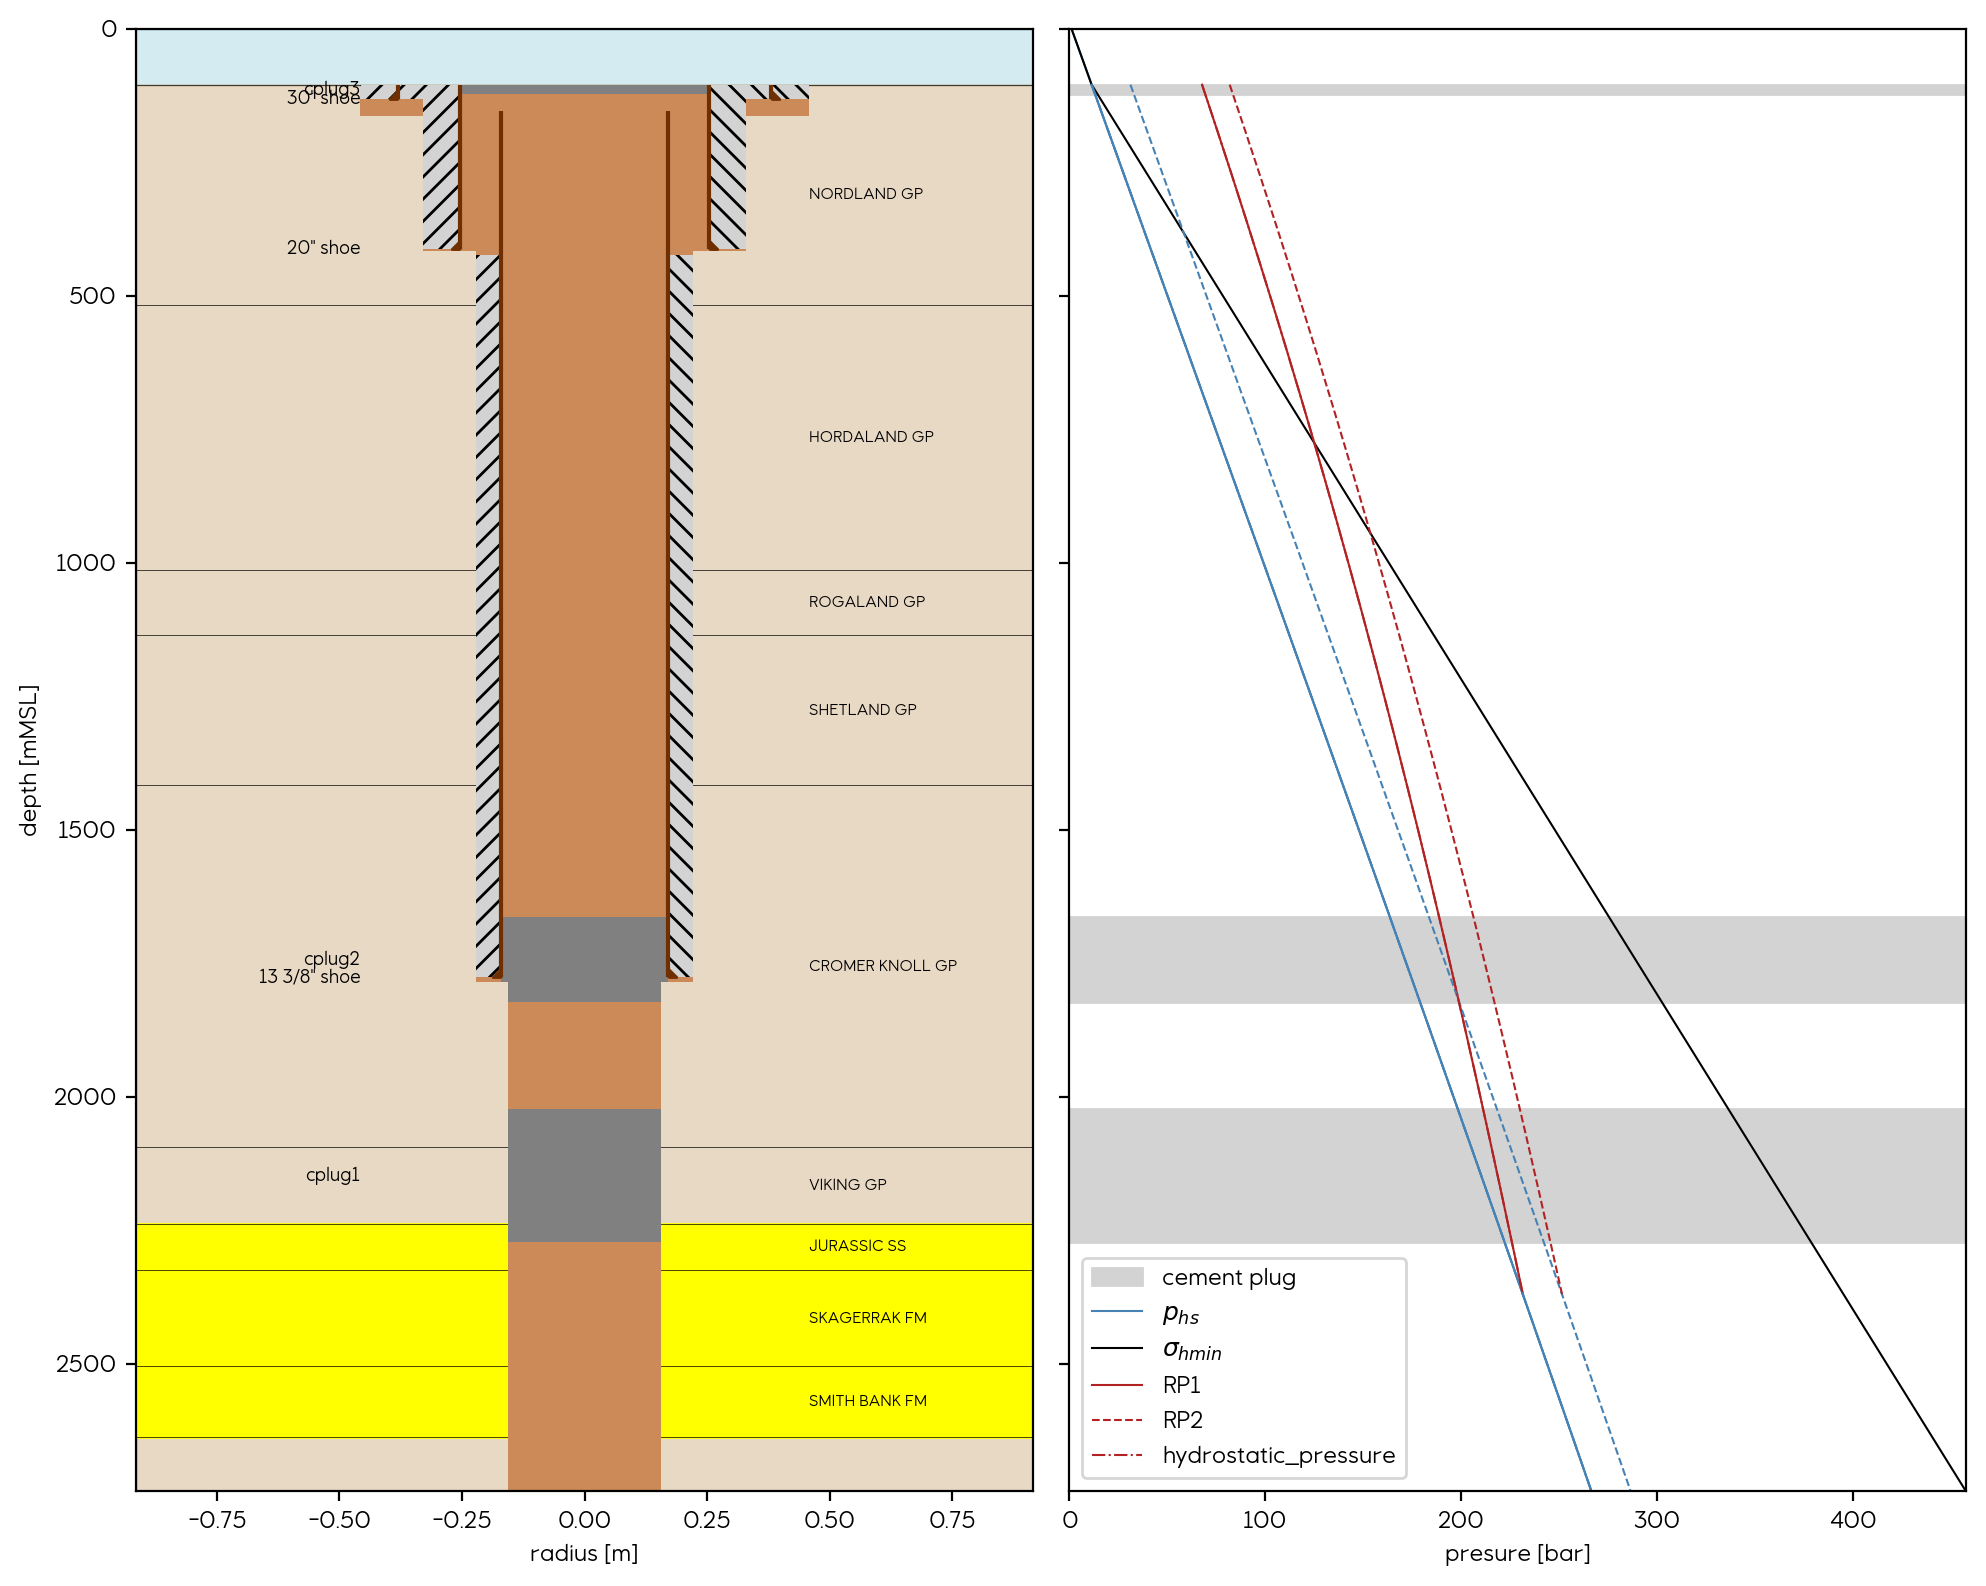

In [17]:
my_pressure = Pressure(
    header      = well_csv['well_header'],
    reservoir_P = well_csv['reservoir_pressure'],
    co2_datum   = well_csv['co2_datum'],
    pvt_path    = pvt_path,
)

#Plot sketch, pressures
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(10, 8))
plot_sketch(my_well, ax=ax1)
plot_pressure(my_pressure, my_well.geology, my_well.barriers, ax=ax2)

fig.tight_layout()

fig.savefig(sim_path/'fig_well_sketch_press.png')

# Build Coarse grid

In [18]:
tops_df = pd.DataFrame(my_well.geology)


tops = 4  #Fix depth gap at top of mesh
layer_noc = 400
water_depth = my_well.header['sf_depth_msl']


water_nz = 1  #No. layers representing water column
ob_nz = 9 # No. layers representing overburden
res_nz = 50  # No. laters representing reservoir
res_dz = 5 # vertical thickness reservoir cells
res_depth = tops_df[tops_df.reservoir_flag]['top_msl'].iloc[0]

In [19]:
#If water depth is more than half of the overburden cell thickness (dz) then don't do the "split" of the first top ob layer.
WATER_DEPTH_OB_CRITERIA = 0.5

#Make the TOPS part
result  =  "EQUALS\n"
result += f"TOPS {int(tops)} 4* 1 1 /\n/\n\n"

#Normalize, only interested in delta-depths from tops.
res_depth   -= tops

#Getting overburden dz. This first ob layer is later split into water and ob
ob_dz = res_depth/ob_nz

#Getting the water part
result += "DZ\n"
result += f"{layer_noc}*{water_depth}"
cum_dz = water_depth

#Getting the first OB layer thickness
dz = ob_dz - water_depth
if dz > WATER_DEPTH_OB_CRITERIA*ob_dz:  #If water layer is too thick - do not do this split 
    result += f" {layer_noc}*{dz:.0f} " #The first layer in the overburden
    ob_nz  -= 1                         #Now the first OB layer is used to adjust to the water depth. Not sure why we would like to do this
    cum_dz += dz

#Getting rest of the overburden
dz = (res_depth - cum_dz)/ob_nz               #Remaining depth interval to fill with cells
result += f" {layer_noc*ob_nz:.0f}*{dz:.0f} "

#Getting the reservoir
result += f" {layer_noc*res_nz:.0f}*{res_dz:.0f} /\n\n\n"

tops_file = sim_path / 'include' / 'tops_dz.inc'

with open(tops_file, 'w') as op_file:
    op_file.write(result)


# Run coarse simulation

In [20]:
# file name (coarse grid) for pflotran run
run_config_coarse = simcase1_path.with_suffix('.in')
run_config_coarse

PosixPath('/scratch/SCS/gpb/SCREEN/cases/cosmo/model/PFT_SCREEN_NOSIM.in')

In [21]:
%%bash -s "$run_config_coarse"

runpflotran1.8 -i -nm 6 $1


/scratch/SCS/gpb/SCREEN/cases/cosmo/model /scratch/SCS/gpb/SCREEN/junk/SCREEN/notebooks


 Pflotran 1.8 sv6+
 Pflotran was compiled on: Oct 25 2023 21:47:59            
 RESERVOIR_DEFAULTS option has been selected
 Pflotran card:: DIMENS                          
 Pflotran card:: EQUALS                          
 Pflotran card:: DZ                              
 Pflotran card:: EQUALS                          
 Pflotran card:: COPY                            
 Pflotran card:: MULTIPLY                        
 Pflotran card:: MINPV                           
 Calculating pore volumes
 Calculating connections
 Ncell=       24000  Nact=       24000  Nconn=       69200  Nflt=           0  Npo=           0
 Reading SUBSURFACE cards:
 Pflotran card:: GRID
 Pflotran card:: REFERENCE_PRESSURE
 Pflotran card:: REFERENCE_TEMPERATURE
 Pflotran card:: TIME
 Pflotran card:: OUTPUT
 Pflotran card:: NEWTON_SOLVER
 Pflotran card:: MATERIAL_PROPERTY
   Name :: formation
 "MATERIAL_PROPERTY,rock density units" set to default value.
 "MATERIAL_PROPERTY,specific heat units" set to default valu

/scratch/SCS/gpb/SCREEN/junk/SCREEN/notebooks


# Build LGR

In [19]:

##### LGR grid 
lgr = LGRBuilder(simcase1, 
                 annulus_df, 
                 drilling_df,
                 Ali_way)

Coarse grid dimension: nx=20, ny=20, nz=60
Minimimum grid size is 5.24 cm
LGR dimension: nx=22, ny=22, nz=150


In [26]:
sim_path

PosixPath('/scratch/SCS/gpb/SCREEN/cases/cosmo')

In [27]:
############### generate and output LGR #####################

LGR_NAME = 'TEMP_LGR'
output_dir = sim_path/'include'


# Write LGR file
gap_casing_df = lgr.build_grdecl(output_dir, 
                                 LGR_NAME,
                                 drilling_df,
                                 casings_df,
                                 barriers_mod_df)

gap_casing_df

...Prints isolating OVB from reservoir keywords in TEMP_LGR.grdecl file
...Prints CARFIN Keywords in TEMP_LGR.grdecl file
...Prints isolating OVB from reservoir in the LGR in TEMP_LGR.grdecl file
...reopenID = 12.25 ...
Output LGR CARFIN to:  /scratch/SCS/gpb/SCREEN/cases/cosmo/include/TEMP_LGR.grdecl


,diameter_m,top_msl,bottom_msl,toc_msl,boc_msl,cb_perm,n_grd_id,k_min,k_max,ij_min,ij_max,toc_k_min,toc_k_max
0,0.762000,105,131,105,131,300,12,10,11,5,16,10,11
1,0.508000,131,412,131,412,5,8,11,26,7,14,11,26
2,0.339725,412,1776,423,1776,500,6,26,81,8,13,27,81


In [28]:
output_dir

PosixPath('/scratch/SCS/gpb/SCREEN/cases/cosmo/include')

# Run LGR simulation

In [24]:
# file name (LGR grid) for pflotran run
run_config_lgr = simcase2_path.with_suffix('.in')
run_config_lgr

PosixPath('/scratch/SCS/gpb/SCREEN/cases/cosmo/model/PFT_SCREEN.in')

In [25]:
%%bash -s "$run_config_lgr"

runpflotran1.8 -i -nm 6 $1


/scratch/SCS/gpb/SCREEN/cases/cosmo/model /scratch/SCS/gpb/SCREEN/junk/SCREEN/notebooks


 Pflotran 1.8 sv6+
 Pflotran was compiled on: Oct 25 2023 21:47:59            
 RESERVOIR_DEFAULTS option has been selected
 Pflotran card:: DIMENS                          

 ERROR: File: "../include/../include/TEMP_LGR.grdecl" not found.

 Stopping!
 
 ------------------------------------------------------------------------------

  Helpful information for debugging the input deck:

      Filename : ../include/../include/tops_dz.inc
   Line Number : 1
       Keyword : SUBSURFACE,GRID,
 
 ------------------------------------------------------------------------------

 ERROR: While reading "GRDECL file" under keyword: Unable to read from GRDECL file.

 Stopping!


--------------------------------------------------------------------------
Primary job  terminated normally, but 1 process returned
a non-zero exit code. Per user-direction, the job has been aborted.
--------------------------------------------------------------------------
--------------------------------------------------------------------------
mpirun detected that one or more processes exited with non-zero status, thus causing
the job to be terminated. The first process to do so was:

  Process name: [[20750,1],0]
  Exit code:    87
--------------------------------------------------------------------------


cat: PFT_SCREEN-mas.dat: No such file or directory


/scratch/SCS/gpb/SCREEN/junk/SCREEN/notebooks


### Load files from pflotran simulation

In [23]:
# load LGR grid from simulation file
grid_lgr = GridLGR(simcase2)

# Visualization

In [24]:
import inspect
inspect.getfile(plot_grid)

'/project/dig_ccs_sub/users/hzh/projects/SCREEN/src/WellClass/libs/plotting/plot_grids.py'

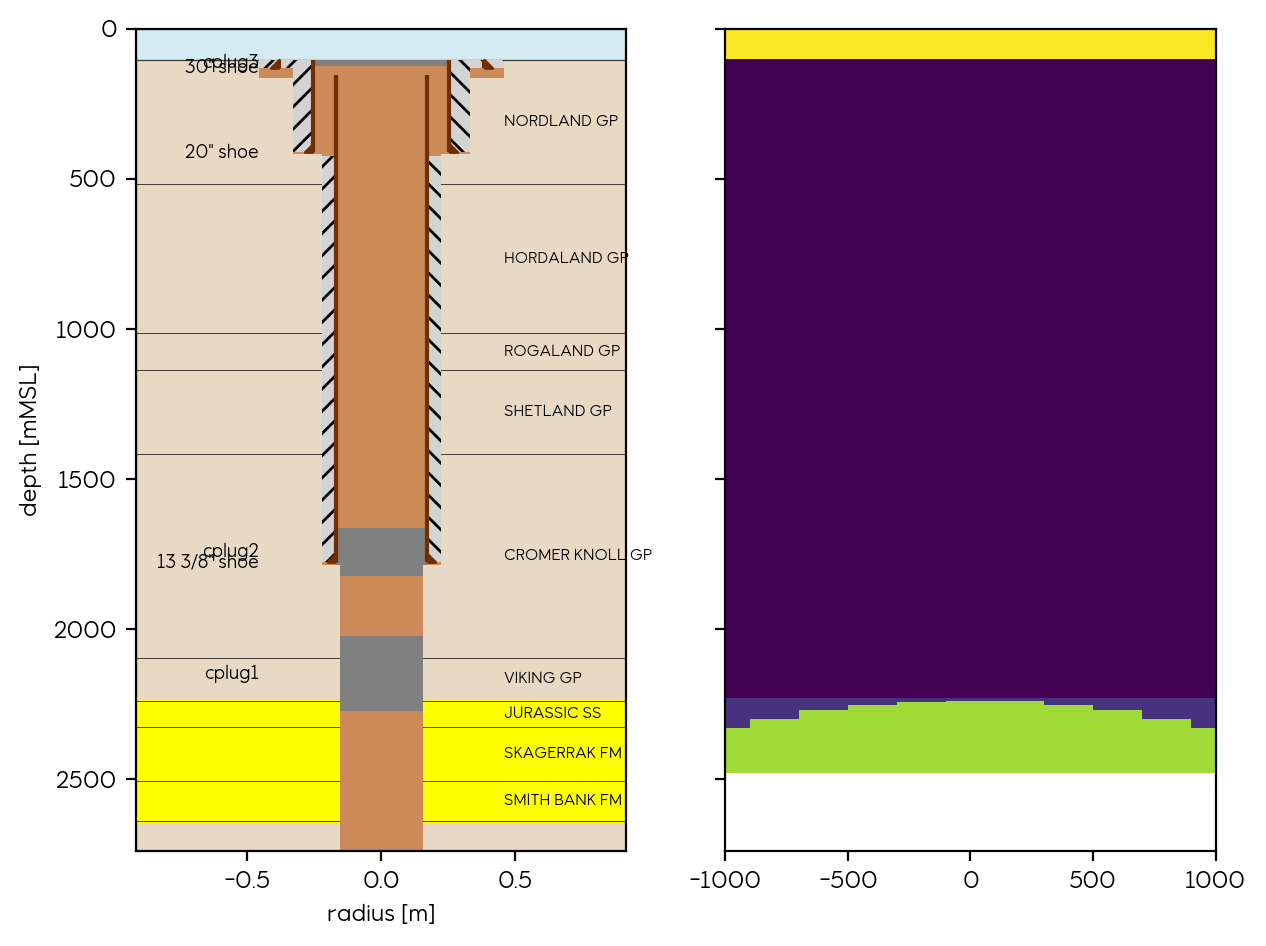

In [25]:
# coarse grid
grid_coarse = lgr.grid_coarse

plot_grid(my_well, grid_coarse)


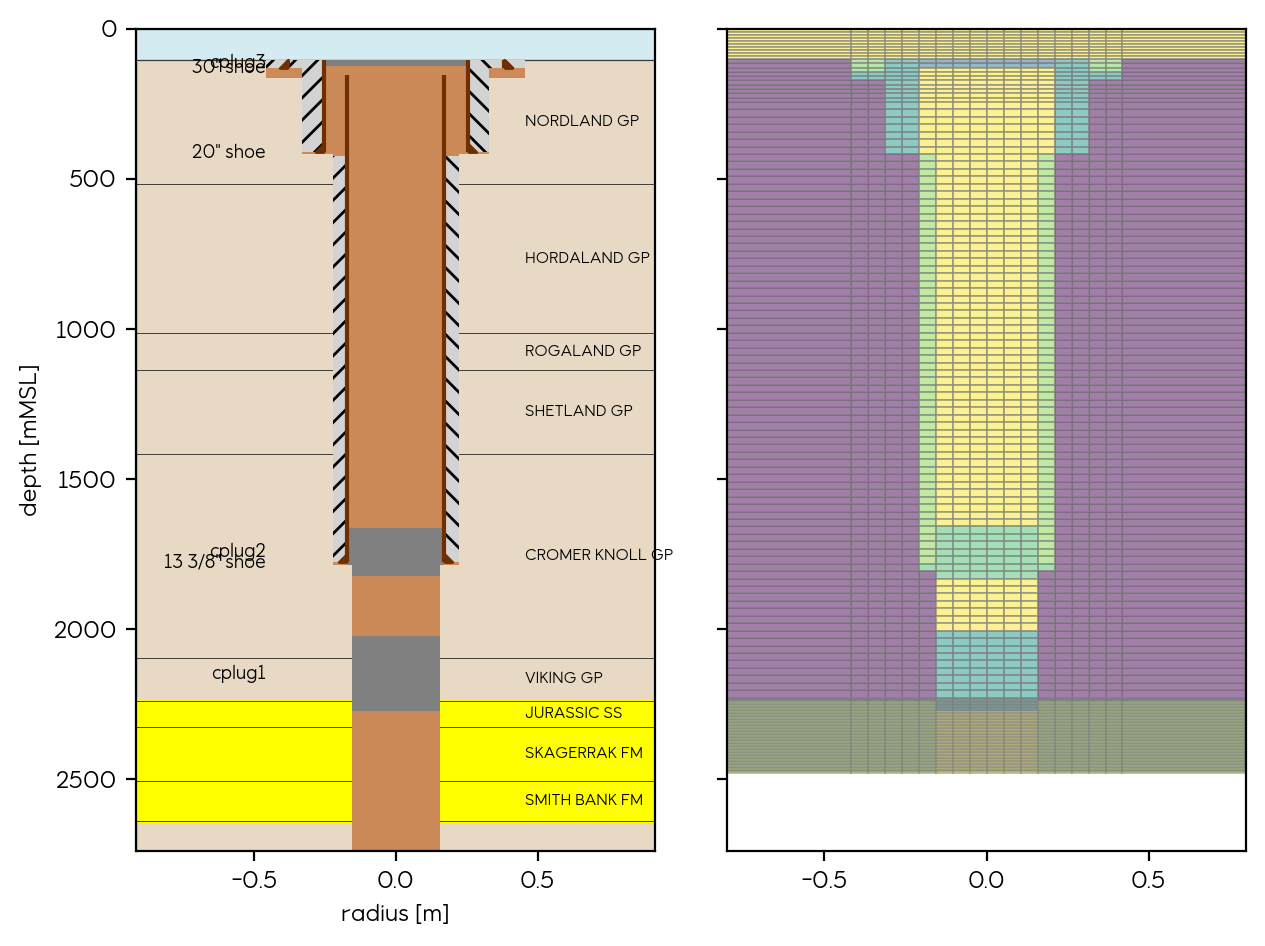

In [26]:
# LGR grid from dataframe
grid_refine = lgr.grid_refine

plot_grid(my_well, grid_refine)

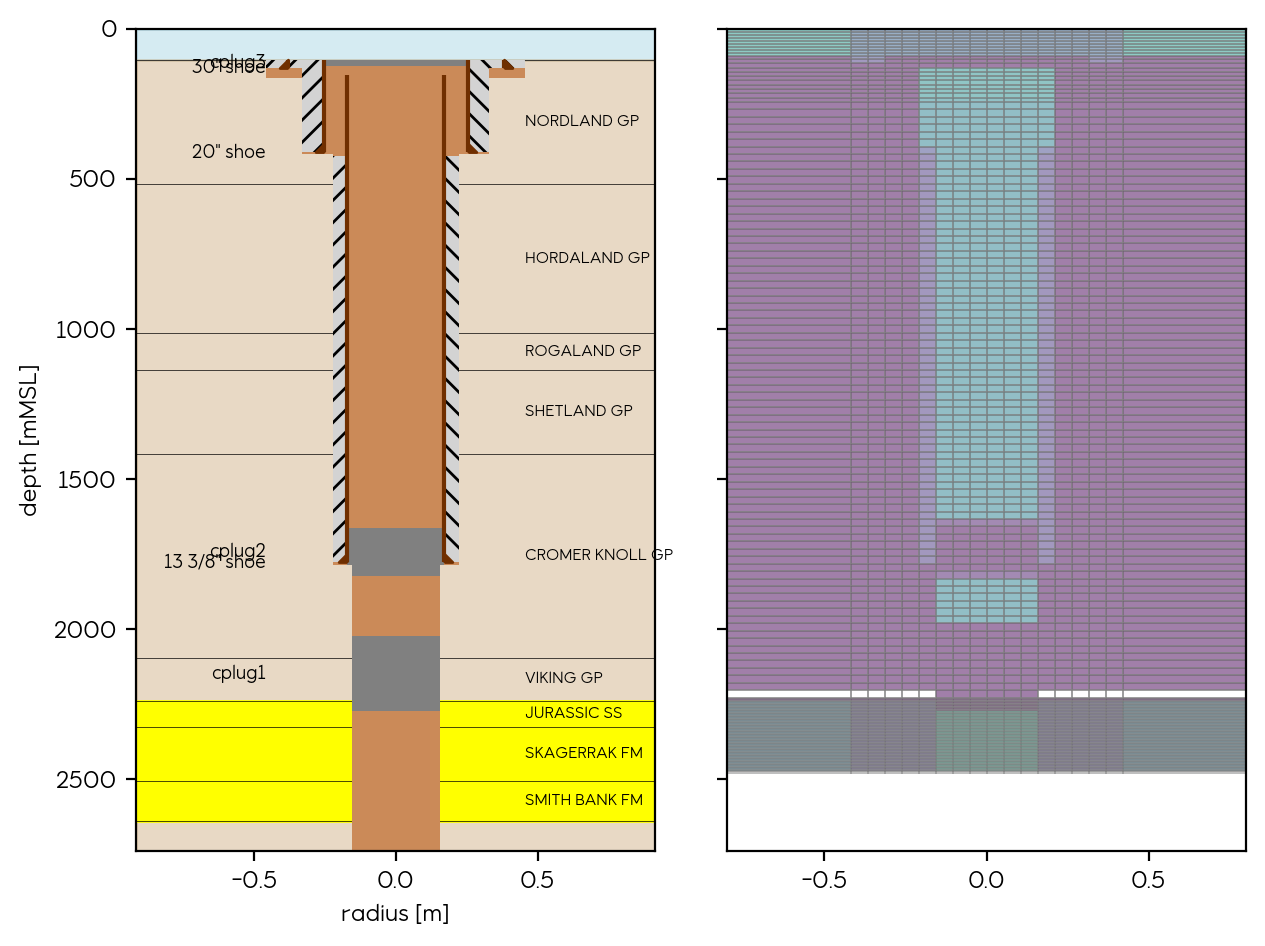

In [36]:
# LGR grid from pflotran output
plot_grid(my_well, grid_lgr, prop='TRANZ')

# Other Qcs

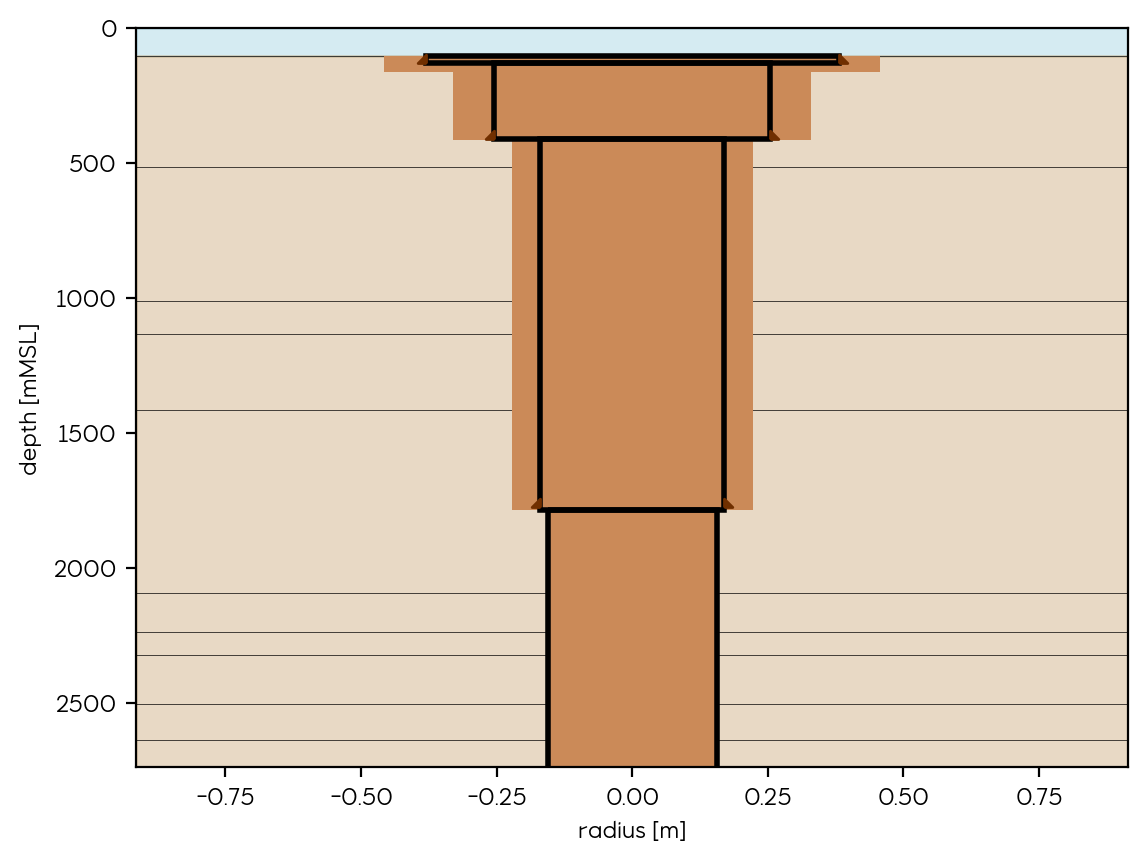

In [28]:
# testing plot_sketch
DEBUGGING = True
if DEBUGGING:
    from src.WellClass.libs.plotting import plot_sketch
    plot_sketch(my_well, 
                draw_annotation=False,
                draw_open_hole=True,
                draw_cement_bond=False,
                draw_casings=False, 
                draw_barriers=False)

In [29]:
ip_grid = grid_refine.mesh_df.sort_values(by=["k","j","i"])

In [30]:
type(ip_grid)

pandas.core.frame.DataFrame

In [31]:
# lgr mesh from simulation file
lgr_index = grid_lgr.lgr_index

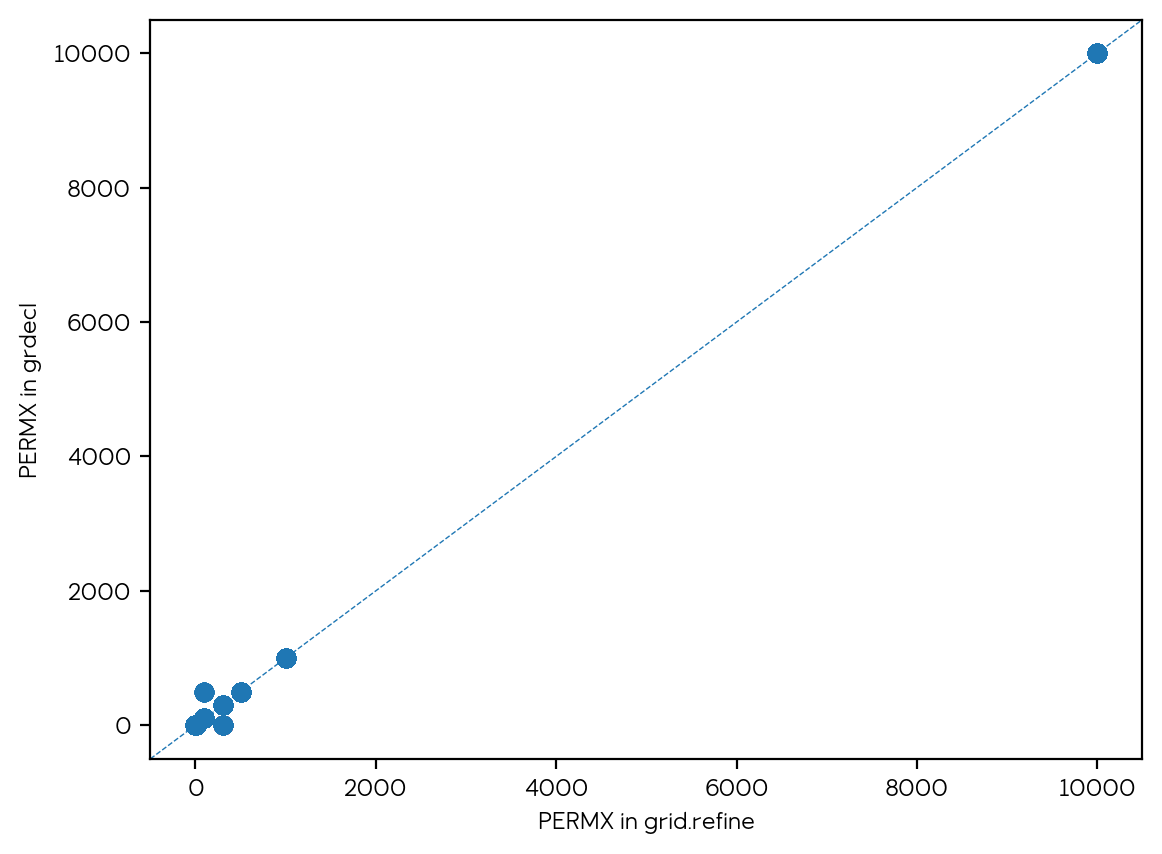

In [32]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots()
prop = 'PERMX'
ax.scatter(ip_grid[prop], lgr_index[prop])
ax.set_xlabel(f'{prop} in grid.refine')
ax.set_ylabel(f'{prop} in grdecl')
ax.plot([0, 1], [0, 1], transform=ax.transAxes, lw=0.5, ls='--')

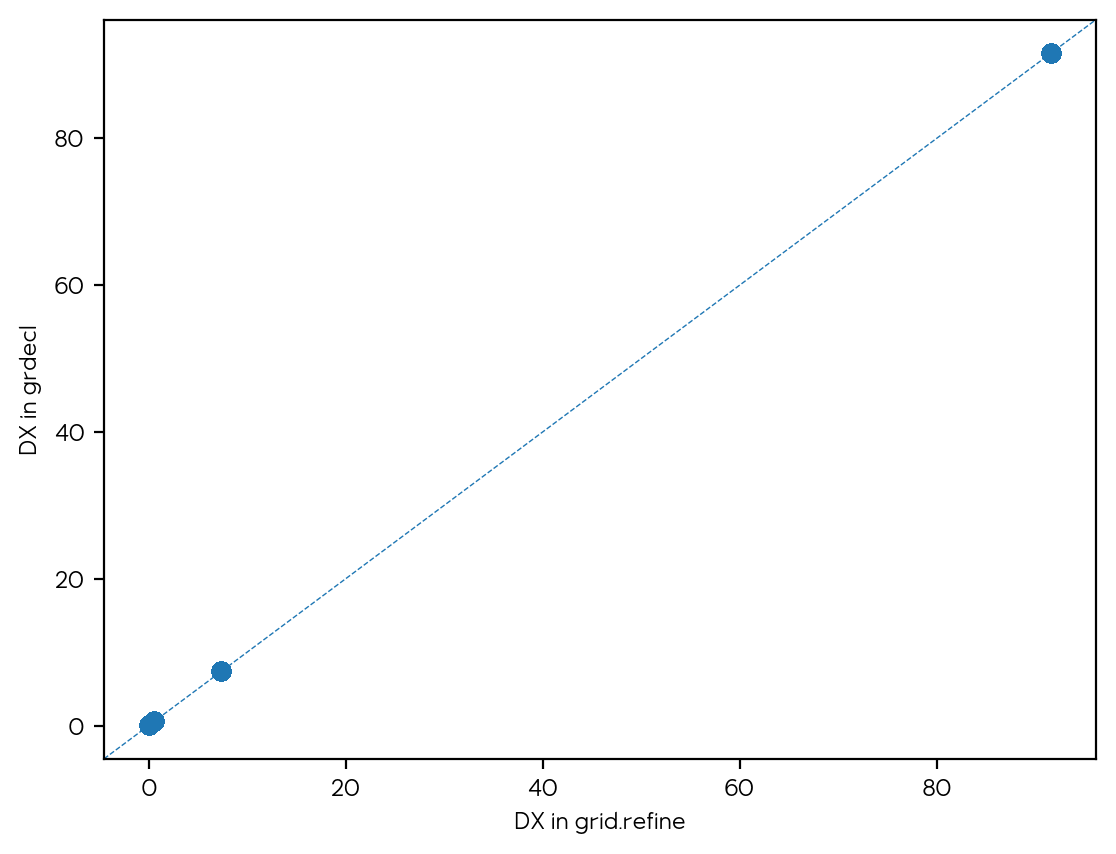

In [33]:
fig, ax = plt.subplots()
prop = 'DX'
ax.scatter(ip_grid[prop], lgr_index[prop])
ax.set_xlabel(f'{prop} in grid.refine')
ax.set_ylabel(f'{prop} in grdecl')
ax.plot([0, 1], [0, 1], transform=ax.transAxes, lw=0.5, ls='--')

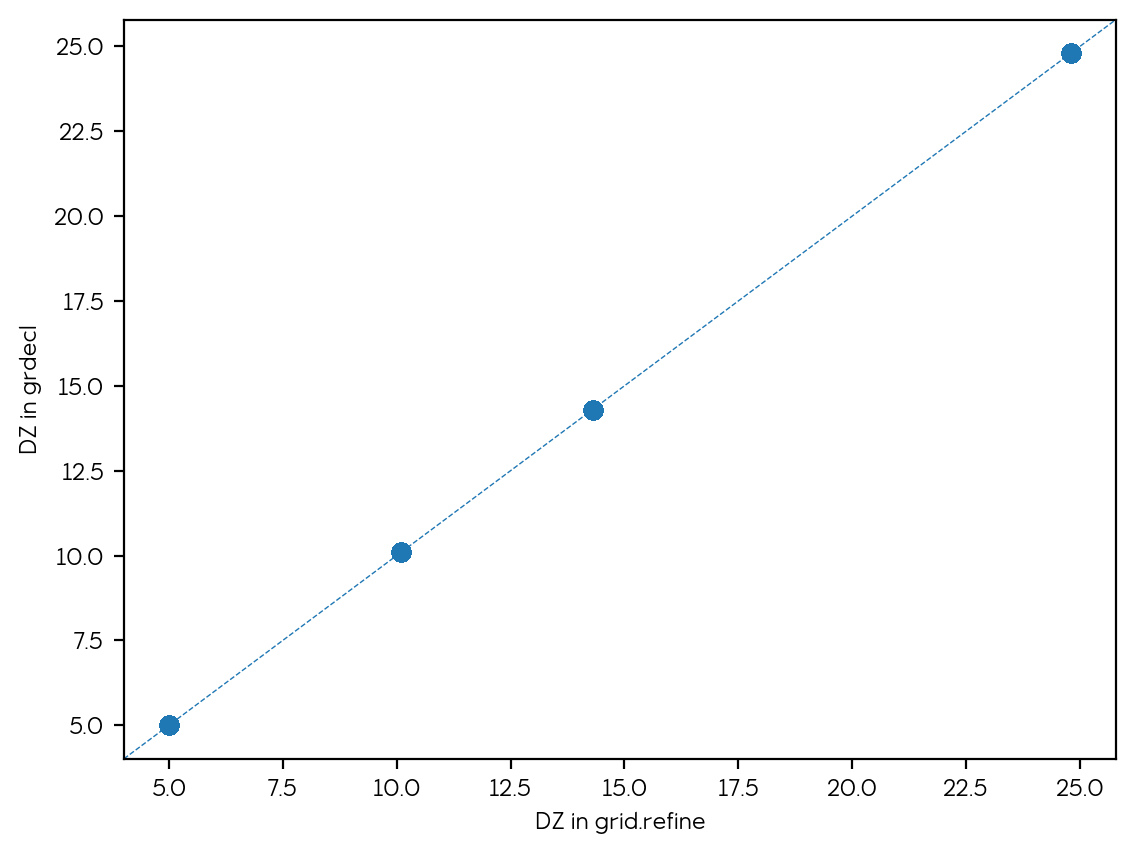

In [34]:
fig, ax = plt.subplots()
prop = 'DZ'
ax.scatter(ip_grid[prop], lgr_index[prop])
ax.set_xlabel(f'{prop} in grid.refine')
ax.set_ylabel(f'{prop} in grdecl')
ax.plot([0, 1], [0, 1], transform=ax.transAxes, lw=0.5, ls='--')